# Load images from new Echelle

## Imports and Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go
from lmfit.models import GaussianModel
from ipywidgets import interact,widgets
from intersect import intersection

In [6]:
# Don't know how to import locally, so I just use %run
%run ../tools/echelle.py

In [7]:
files_cmos = {
    "orders": "pattern_cmos.txt",
    "wavelength": "Th_wavelength_CMOS.txt",
    "sphr": "sphere_CMOS.sif",
    "bkgr": "sphere_CMOS_bkg.sif",
    "integral": "integrating_sphere.txt",
}
files_ccd = {
    "orders": "pattern.txt",
    "wavelength": "Th_wavelength.txt",
    "sphr": "absolute_20170613_b8_0.2_v2.sif",
    "bkgr": "absolute_20170613_b8_0.2_bkg.sif",
    "integral": "integrating_sphere.txt",
}
bpth = '../resources/calibration_files'

In [11]:
%run ../tools/echelle.py
cb = Calibrations(bpth,files_cmos)
cb.start()

<Figure size 432x288 with 0 Axes>

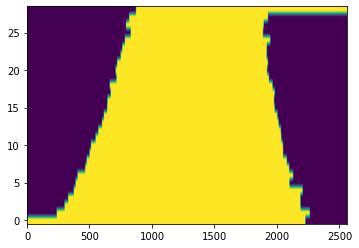

In [13]:
plt.imshow(cb.order_borders,aspect=60,origin='lower')

In [9]:
th = EchelleImage(os.path.join(bpth,'ThAr_10.0s_16bit.sif'),clbr=cb)
th.calculate_order_spectra()
th.correct_order_shapes()
th.calculate_spectra()

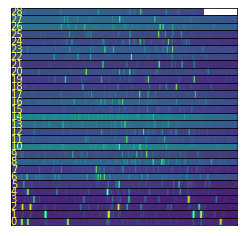

In [10]:
th.plot_cut_image(0,aspect=5)

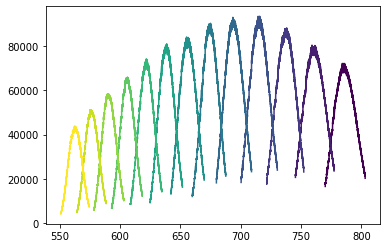

In [11]:
orders = range(13)
clrs = plt.cm.viridis(np.linspace(0,1,len(orders)))
for i,o in enumerate(orders):
    plt.plot(th.clbr.order_wavel[o],th.clbr.sphr.order_spectra[0, o],c=clrs[i])    

In [12]:
    def calculate_order_borders(self):
        """Calculate mask for the orders from a Integrating Sphere Image
        sphr - EchelleImage('IntegratingSphere.SIF')
        """

        def isc(x1, y1, x2, y2):
            """
            For two neighbor orders with lambda \propto -pix
            find end index for x1 and start index for x2 so they will
            not intersect
            x1 < ind1 and x2 >= ind2
            """
            from scipy.interpolate import interp1d

            # remove np.nan from vectors
            i1 = ~np.isnan(x1)
            i2 = ~np.isnan(x2)
            x1 = x1[i1]
            y1 = y1[i1]
            x2 = x2[i2]
            y2 = y2[i2]

            if x1[0] < x2[0]:
                # swap places
                a, b = x1, y1
                x1, y1 = x2, y2
                x2, y2 = a, b

            f1 = interp1d(x1, y1, 1)
            f2 = interp1d(x2, y2, 1)
            x = np.linspace(*sorted([x1[0], x1[-1], x2[0], x2[-1]])[1:-1], len(x2))
            x0 = x[np.argmin(np.abs(f1(x) - f2(x)))]
            ind2 = np.where(x2 <= x0)
            ind1 = np.where(x1 > x0)

            return ind1[0][-1] + 1, ind2[0][0]

        self.sphr.correct_order_shapes()

        nord = self.order_wavel.shape[0]

        brdr = [
            isc(
                remove_npnans(self.order_wavel[o]),
                remove_npnans(self.sphr.order_spectra[0, o]),
                remove_npnans(self.order_wavel[o + 1]),
                remove_npnans(self.sphr.order_spectra[0, o + 1]),
            )
            for o in range(nord - 1)
        ]

        brdrs = np.append(np.insert(np.array(brdr), 0, 0), [self.DIMW]).reshape(nord, 2)

        r = np.arange(self.DIMW)[:, None]
        b = (brdrs[:, 0] <= r) & (r <= brdrs[:, 1])
        self.order_borders = b.T
        # self.wavelength = remove_npnans(self.order_wavel[self.order_borders])
        self.wavelength = self.order_wavel[self.order_borders]

In [13]:
sp = Spectrum(th)

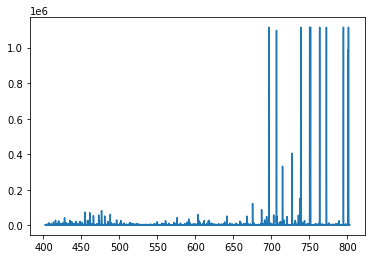

In [14]:
x = sp.wavelength
y = sp.counts[0]
plt.plot(x,y)

In [15]:
i = th.order_spectra[0]
i[0].shape

(2560,)

In [16]:
cb.order_borders[0]

array([ True,  True,  True, ..., False, False, False])

In [17]:
i[0][cb.order_borders[0]]

array([3461., 3221., 3143., ..., 2970., 2851., 2993.])

In [18]:
from scipy.interpolate import interp1d

h2 = th
o = 10
x1 = h2.clbr.order_wavel[o]
y1 = h2.clbr.sphr.order_spectra[0, o]
x2 = h2.clbr.order_wavel[o + 1]
y2 = h2.clbr.sphr.order_spectra[0, o + 1]

# remove np.nan from vectors
i1 = ~np.isnan(x1)
i2 = ~np.isnan(x2)
x1 = x1[i1]
y1 = y1[i1]
x2 = x2[i2]
y2 = y2[i2]

f1 = interp1d(x1, y1, 1)
f2 = interp1d(x2, y2, 1)
x = np.linspace(*sorted([x1[0], x1[-1], x2[0], x2[-1]])[1:-1], len(x2))
x0 = x[np.argmin(np.abs(f1(x) - f2(x)))]
ind2 = np.where(x2 <= x0)
ind1 = np.where(x1 > x0)

ind1[0][-1] + 1, ind2[0][0]

(2047, 548)

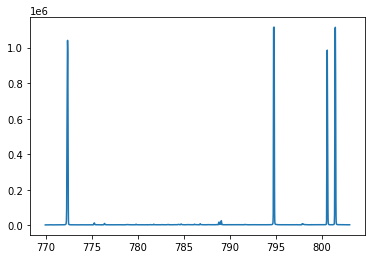

In [19]:
spec0 = th.order_spectra[0][0]
w = cb.order_wavel[0]
plt.plot(w,spec0)

In [20]:
x = th.wavelength
y = th.spectra[0]

pg_data = [go.Scatter(x=x,y=y,name = 'a')]
fig = go.Figure(data=pg_data)
fig.update_layout(template='plotly_white')
fig.show()

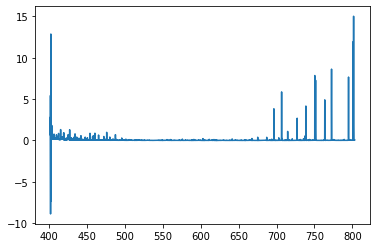

In [21]:
sp = Spectrum(h2)
plt.plot(sp.wavelength,sp.wm[0])

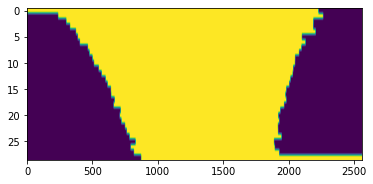

In [22]:
plt.imshow(cb.order_borders,aspect=40)

In [23]:
def isc(x1, y1, x2, y2):
    """For two neighbor orders with lambda \propto -pix
    find end index for x1 and start index for x2 so they will
    not intersect
    x1 < ind1 and x2 >= ind2
    """
    from scipy.interpolate import interp1d

    # remove np.nan from vectors
    i1 = ~np.isnan(x1)
    i2 = ~np.isnan(x2)
    x1 = x1[i1]
    y1 = y1[i1]
    x2 = x2[i2]
    y2 = y2[i2]

    f1 = interp1d(x1, y1, 1)
    f2 = interp1d(x2, y2, 1)
    x = np.linspace(*sorted([x1[0], x1[-1], x2[0], x2[-1]])[1:-1], len(x2))
    x0 = x[np.argmin(np.abs(f1(x) - f2(x)))]
    ind2 = np.where(x2 <= x0)
    ind1 = np.where(x1 > x0)

    return ind1[0][-1] + 1, ind2[0][0]

In [24]:
o = 2
isc(
    h2.clbr.order_wavel[o],
    h2.clbr.sphr.order_spectra[0, o],
    h2.clbr.order_wavel[o + 1],
    h2.clbr.sphr.order_spectra[0, o + 1],
)

(2188, 329)

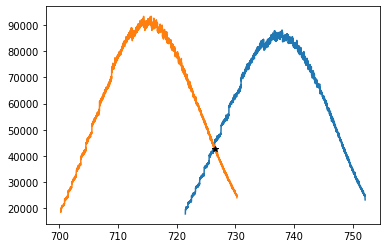

In [25]:
o = 2
x1 = h2.clbr.order_wavel[o]
y1 = h2.clbr.sphr.order_spectra[0, o]
x2 = h2.clbr.order_wavel[o + 1]
y2 = h2.clbr.sphr.order_spectra[0, o + 1]
x,y = intersection(x1,y1,x2,y2)
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x,y,'*k')

In [26]:
from scipy.interpolate import interp1d

o = 2
x1 = h2.clbr.order_wavel[o]
y1 = h2.clbr.sphr.order_spectra[0, o]
x2 = h2.clbr.order_wavel[o + 1]
y2 = h2.clbr.sphr.order_spectra[0, o + 1]
if x1[0]<x2[0]:
    # swap places
    print(x1[0],x2[0])
    a,b = x1,y1
    x1,y1 = x2,y2
    x2,y2 = a,b
# remove np.nan from vectors
i1 = ~np.isnan(x1)
i2 = ~np.isnan(x2)
x1 = x1[i1]
y1 = y1[i1]
x2 = x2[i2]
y2 = y2[i2]

f1 = interp1d(x1, y1, 1)
f2 = interp1d(x2, y2, 1)
x = np.linspace(*sorted([x1[0], x1[-1], x2[0], x2[-1]])[1:-1], len(x2))
x0 = x[np.argmin(np.abs(f1(x) - f2(x)))]
ind2 = np.where(x2 <= x0)
ind1 = np.where(x1 > x0)

ind1[0][0] + 1, ind2[0][-1]

(1, 2559)

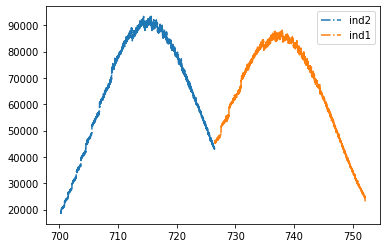

In [27]:
#plt.plot(x,f1(x),label='1')
#plt.plot(x,f2(x),label='2')
#plt.plot(x,np.abs(f1(x)-f2(x)))
#plt.axvline(x0,c='k')
plt.plot(x2[ind2],y2[ind2],'-.',label='ind2')
plt.plot(x1[ind1],y1[ind1],'-.',label='ind1')
plt.legend()

In [28]:
x1[0]>x2[0]

True

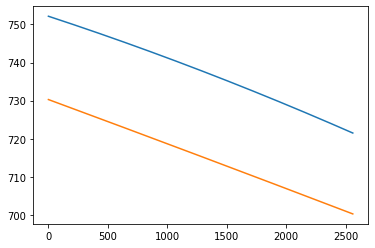

In [29]:
plt.plot(x1)
plt.plot(x2)

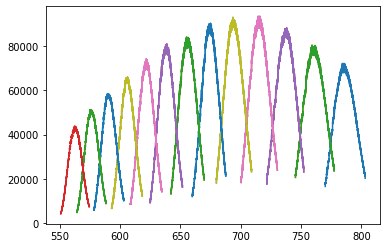

In [30]:
for o in range(12):
    plt.plot(h2.clbr.order_wavel[o],h2.clbr.sphr.order_spectra[0, o])
    plt.plot(h2.clbr.order_wavel[o + 1],h2.clbr.sphr.order_spectra[0, o + 1])